#### Oppgave 1

### a)

In [2]:
import xarray as xr
from scipy.interpolate import RectBivariateSpline
import numpy as np
from matplotlib import pyplot as plt
from time import time
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import random


In [3]:
def f(x,t,epsilon, w):
    """""
    function calculates function f used in velocity equation.
    :param x: array
    :param t: array
    :param epsilon: float
    :param w: float
    return array
    """""
    return epsilon*np.sin(w*t)*x**2 + (1-2*epsilon*np.sin(w*t))*x
def del_f(x,t,epsilon, w):
    """""
    function calculates function f used in velocity equation.
    :param x: array
    :param t: array
    :param epsilon: float
    :param w: float
    return array
    """""
    return epsilon*np.sin(w*t)*2*x + (1-2*epsilon*np.sin(w*t))

def velocity_x(x: np.ndarray, y: np.ndarray, t: np.ndarray , A: float, epsilon: float, w: float):
    """""
    function calculates velocity in x direction.
    :param x: array
    :param y: array
    :param t: array
    :param A: float
    :param epsilon: float
    :param w: float
    return array
    """""
    return -np.pi*A*np.sin(np.pi*f(x,t, epsilon, w))*np.cos(np.pi*y)
def velocity_y(x: np.ndarray, y: np.ndarray, t: np.ndarray , A: float, epsilon: float, w: float):
    """""
    function calculates velocity in y direction.
    :param x: array
    :param y: array
    :param t: array
    :param A: float
    :param epsilon: float
    :param w: float
    return array
    """""
    return np.pi*A*np.cos(np.pi*f(x,t, epsilon, w))*np.sin(np.pi*y)*del_f(x,t, epsilon, w)
def Heun(init_pos: tuple, t_end: int, h: float, A: float, epsilon: float, w: float):
    """""
    function uses the Heun integrate method to calculate the next position for the particle
    :param init_pos: tuple
    :param t_end: int
    :param h: float
    :param A: float
    :param epsilon: float
    :param w: float
    return [array, array]
    """""
    num_particles = init_pos.shape[2]
    
    t = 0
    steps = int(t_end / h)
    x = np.empty((steps + 1, 2, num_particles))
    x[:, :, :] = init_pos

    for i in range(steps):
        k_1_x = velocity_x(x[i, 0, :], x[i, 1, :], i, A, epsilon, w)
        k_1_y = velocity_y(x[i, 0, :], x[i, 1, :], i, A, epsilon, w)

        k_2_x = velocity_x(x[i, 0, :] + k_1_x * h, x[i, 1, :] + k_1_y * h, i + h, A, epsilon, w)
        k_2_y = velocity_y(x[i, 0, :] + k_1_x * h, x[i, 1, :] + k_1_y * h, i + h, A, epsilon, w)

        x_add_x = x[i, 0, :] + (h / 2) * (k_1_x + k_2_x)
        x_add_y = x[i, 1, :] + (h / 2) * (k_1_y + k_2_y)

        x[i + 1, 0, :] = x_add_x
        x[i + 1, 1, :] = x_add_y

    return x

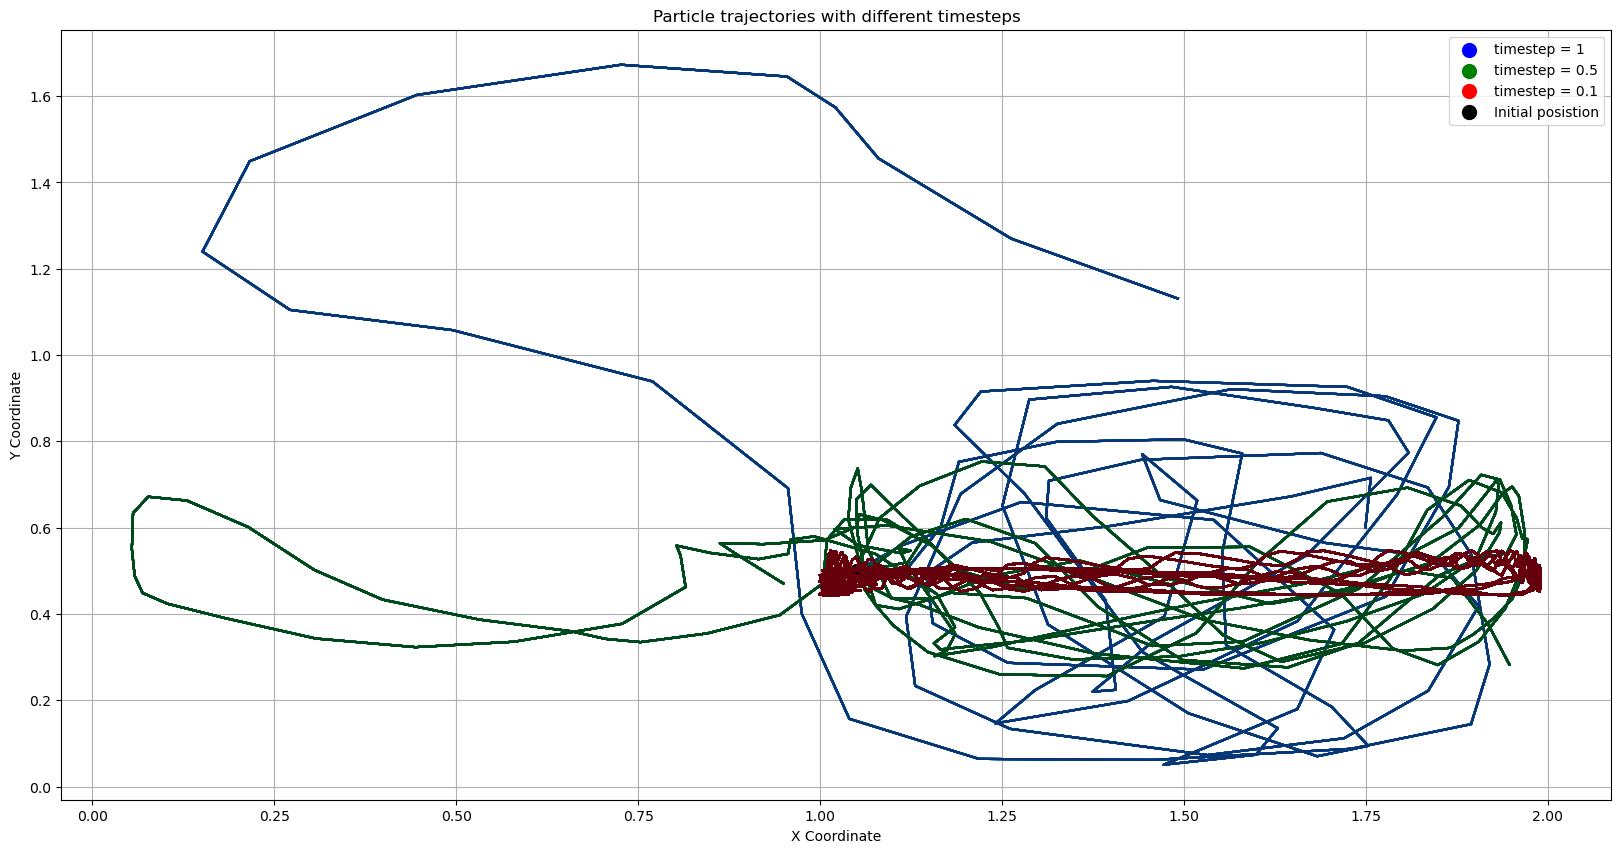

In [4]:
#plotter bevegelsen til partikkel ved hjelp av Heun metode, med gitte initialverdier og konstanter
A = 0.1
epsilon = 0.25
w = 1
init_pos = np.array([[[1.05, 0.5]]]) #startposisjon
t = 50
plt.figure(figsize=(20,10))
positions1 = Heun(init_pos, t, 1, A, epsilon, w) #gir array med posisjon for partikkelen
cmap = plt.get_cmap('Blues')
num_pos = positions1.shape[0]
for idx in range(positions1.shape[0]): #potensielt unødvendig med for-løkke, menmen
    x = positions1[:,:, 0]
    y = positions1[:,:, 1] 
    plt.plot(x, y, color = cmap(idx/num_pos))
plt.scatter(init_pos[:,:,0], init_pos[:,:,1], label = "timestep = 1", color = "blue", s = 99)

positions2 = Heun(init_pos, t, 0.5 , A, epsilon, w) #gir array med posisjon for partikkelen
cmap = plt.get_cmap('Greens')
num_pos = positions2.shape[0]
for idx in range(positions2.shape[0]):
    x = positions2[:,:, 0]
    y = positions2[:,:, 1] 
    plt.plot(x, y, color = cmap(idx/num_pos))
plt.scatter(init_pos[:,:,0], init_pos[:,:,1], label = "timestep = 0.5", color = "green", s = 99)

positions3 = Heun(init_pos, t, 0.1 , A, epsilon, w) #gir array med posisjon for partikkelen
cmap = plt.get_cmap('Reds')
num_pos = positions3.shape[0]
for idx in range(positions3.shape[0]):
    x = positions3[:,:, 0]
    y = positions3[:,:, 1] 
    plt.plot(x, y, color = cmap(idx/num_pos))
plt.scatter(init_pos[:,:,0], init_pos[:,:,1], label = "timestep = 0.1", color = "Red", s = 99)


plt.scatter(init_pos[:,:,0], init_pos[:,:,1], label = "Initial posistion", color = "Black", s = 100)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Particle trajectories with different timesteps')
plt.legend()
plt.grid(True)
plt.show()


finn ut hvilken h som funker, kanskje endre på label, begrunne hvordan h vi går videre med og teste den for t = 100. kanskje endre til subplots

### b)

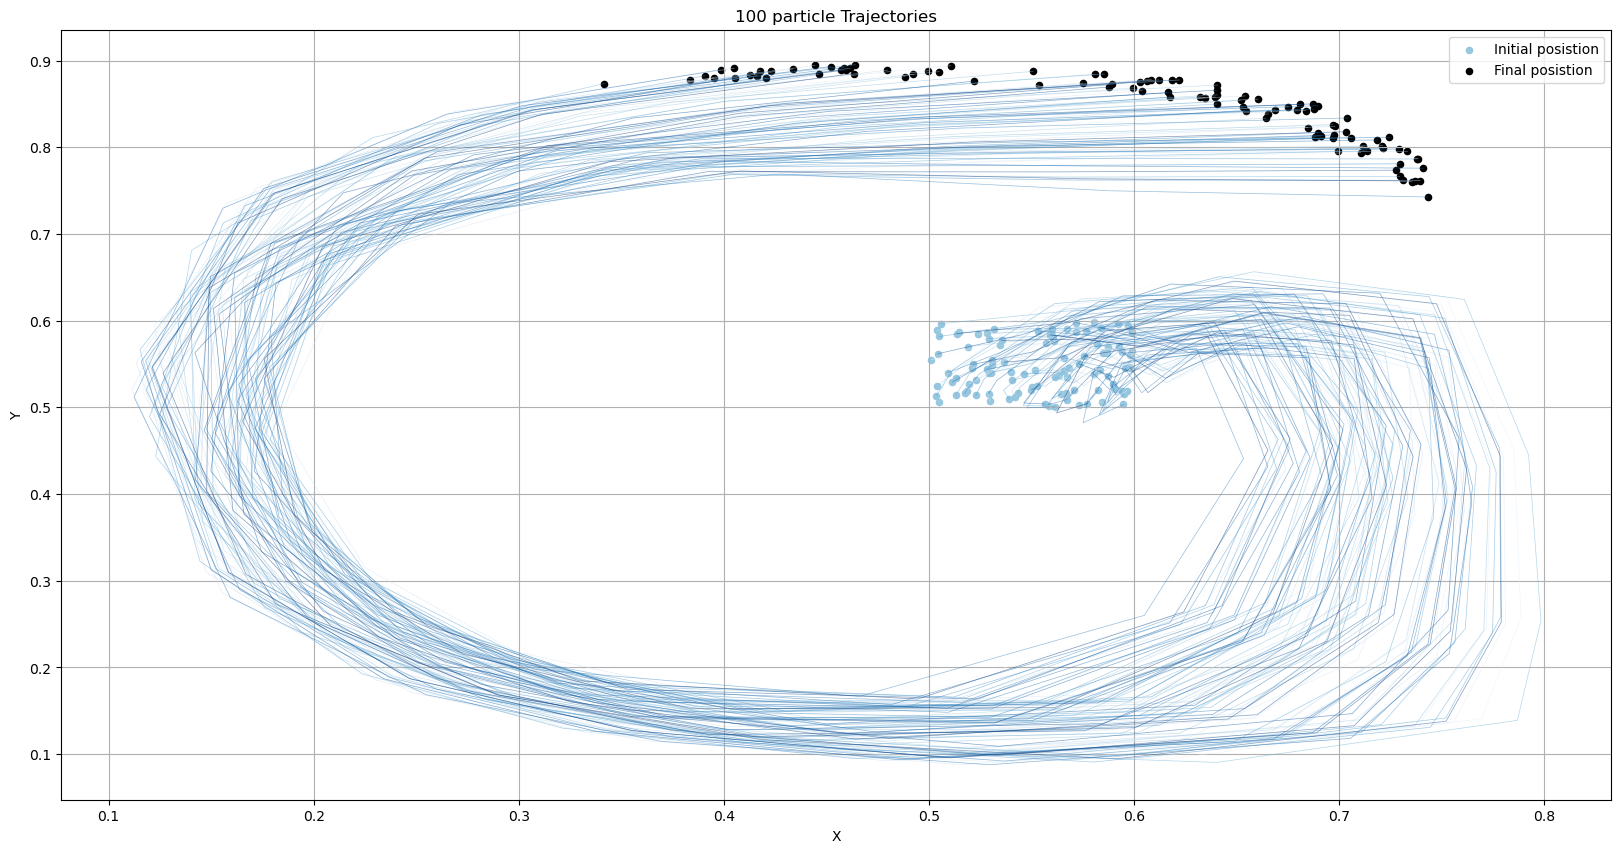

In [5]:
#this is a test

N_p = 100
t = 10
A = 0.1
epsilon = 0.25
w = 1
h = 0.7
x_cor = np.random.uniform(0.5, 0.6, N_p) 
y_cor = np.random.uniform(0.5, 0.6, N_p)
init_pos = np.array([[x_cor, y_cor]])
cmap = plt.get_cmap('Blues')
plt.figure(figsize = (20,10))
positions = Heun(init_pos, t, h, A, epsilon, w)
plt.scatter(positions[0,0,:], positions[0,1,:], label = "Initial posistion", color = cmap(100), s = 20)
plt.scatter(positions[-1,0,:], positions[-1,1,:], label = "Final posistion", color = "black", s = 20)
for i in range(N_p):
    plt.plot(positions[:, 0, i], positions[:, 1, i],color = cmap(i/N_p),  alpha=0.5, lw=0.5)


plt.xlabel('X')
plt.ylabel('Y')
plt.title('100 particle Trajectories')
plt.legend()
plt.grid(True)
plt.show()




### c)

[0.061238765716552734, 0.053078651428222656, 0.04384112358093262, 0.048050642013549805, 0.034572601318359375, 0.04827451705932617, 0.04989457130432129, 0.05005359649658203, 0.0498654842376709, 0.04713749885559082, 0.036280155181884766, 0.05393385887145996, 0.04869341850280762, 0.06134510040283203, 0.05340075492858887, 0.054379940032958984, 0.04491901397705078, 0.052518606185913086, 0.06142759323120117, 0.0578615665435791, 0.05899524688720703, 0.1062161922454834, 0.06276607513427734, 0.05289196968078613, 0.061032772064208984, 0.05602884292602539, 0.047052860260009766, 0.0690145492553711, 0.0591282844543457, 0.062090396881103516, 0.06264996528625488, 0.06386780738830566, 0.05017995834350586, 0.06637263298034668, 0.06673717498779297, 0.05315709114074707, 0.06363415718078613, 0.06699061393737793, 0.04941082000732422, 0.08350944519042969, 0.06849431991577148, 0.048250675201416016, 0.06677579879760742, 0.06940674781799316, 0.06355953216552734, 0.06963944435119629, 0.06395626068115234, 0.0670

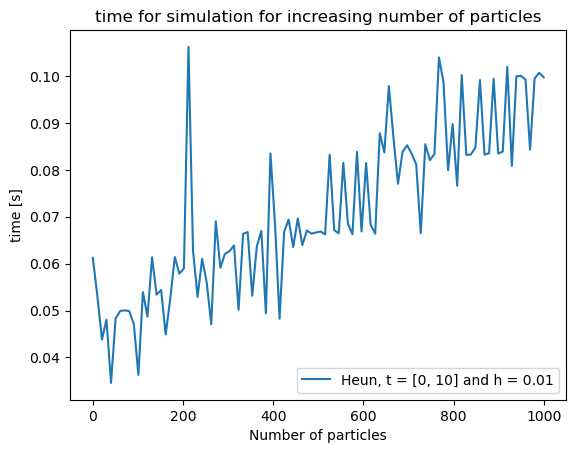

In [8]:
import time
N_p = 1000
steps = 10
h = 0.01
t = 10
time_list = []
for i in range(0,N_p,steps):
    start = time.time()
    ones= np.ones(i)
    init_pos = np.array([[ones*1.05, ones*0.5]])
    Heun(np.array(init_pos), t, h,A, epsilon, w)
    end = time.time()
    time_list.append(end-start)
print(time_list)
plt.plot(np.linspace(0, N_p, len(time_list)), time_list, label = "Heun, t = [0, 10] and h = 0.01")
plt.xlabel("Number of particles")
plt.ylabel("time [s]")
plt.title("time for simulation for increasing number of particles")
plt.legend()
plt.show()
